# SHAP Analysis Guide

## Set-up

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import warnings

In [2]:
plt.style.use("style.mplstyle")
shap.initjs()

## Prepare Data, Model, and SHAP Values

### Load Data

- [Dataset original paper](https://www.law.berkeley.edu/files/Hedonic.PDF)
- [Issues with 'R' variable](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8)

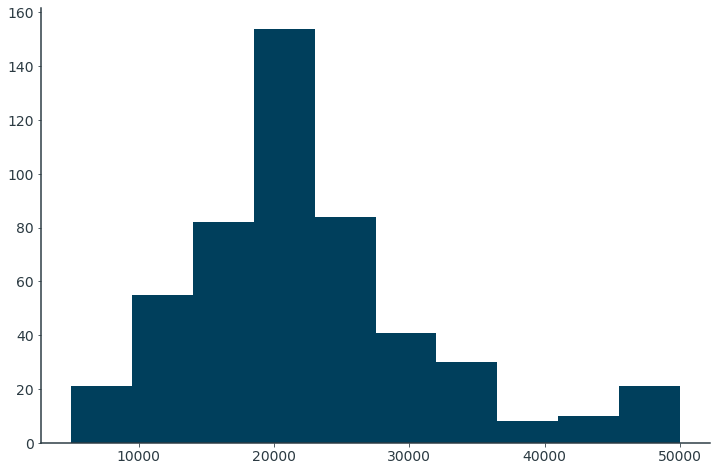

,crime rate,% residential zone,% industrial zone,Charles River,NOX concentration,number of rooms,% built before 1940,remoteness,connectedness,tax rate,pupil-teacher ratio,% working class
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,9.96
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,18.28
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,8.06
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,5.88
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,10.66


In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston = load_boston()
    X = pd.DataFrame(
        boston.data,
        columns=[
            "crime rate",
            "% residential zone",
            "% industrial zone",
            "Charles River",
            "NOX concentration",
            "number of rooms",
            "% built before 1940",
            "remoteness",
            "connectedness",
            "tax rate",
            "pupil-teacher ratio",
            "B",
            "% working class"
        ],
    ).drop("B", axis=1)
    X["% working class"] = X["% working class"] * 2
    y = boston.target * 1000
    df = X.copy()
    df["y"] = y
plt.hist(y)
plt.show()
X.head()

### Train Model

In [4]:
m = lgb.LGBMRegressor()
m.fit(X, y)

LGBMRegressor()

In [5]:
y_pred = m.predict(X)

from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, y_pred, squared=False)
rmse

1310.1544628922263

### Compute SHAP Values

In [6]:
explainer = shap.Explainer(m)
shap_values = explainer(X)

In [7]:
explainer.expected_value

22532.8063239976

## SHAP Analysis

### Local

In [8]:
i_med = np.argsort(y_pred)[len(y_pred)//2]
i_max = np.argmax(y_pred)
i_min = np.argmin(y_pred)

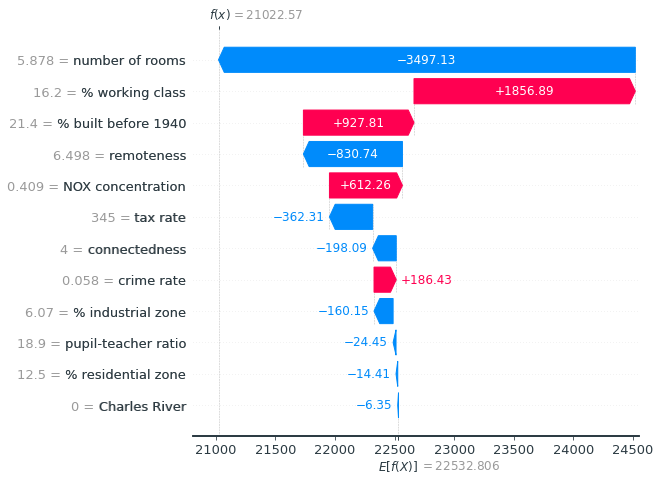

In [9]:
shap.plots.waterfall(shap_values[i_med], max_display=99)

In [10]:
shap.plots.force(shap_values[i_med])

In [11]:
shap.plots.force(shap_values[i_max])

In [12]:
shap.plots.force(shap_values[i_min])

### Global

#### Summary plots

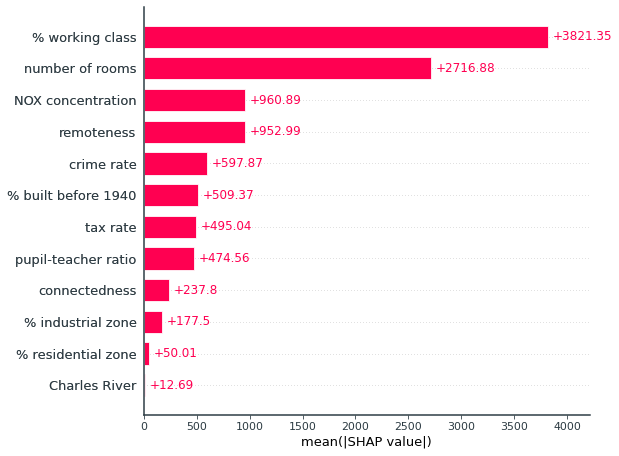

In [13]:
shap.plots.bar(shap_values, max_display=99)

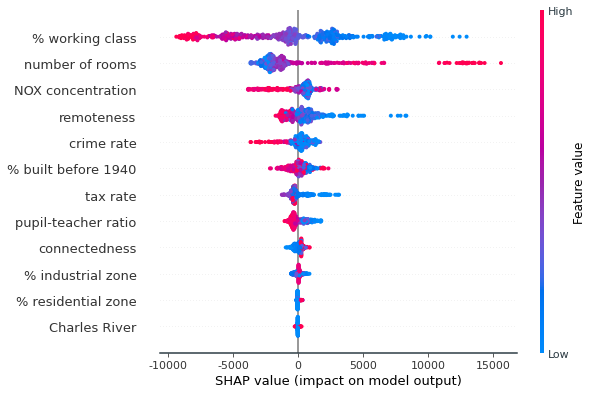

In [14]:
shap.plots.beeswarm(shap_values, max_display=99)

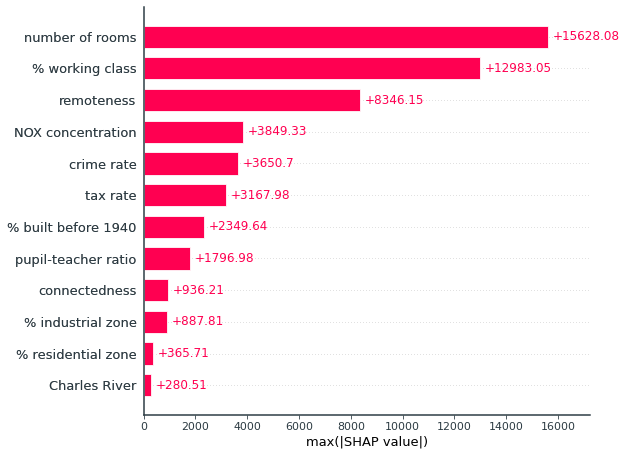

In [15]:
shap.plots.bar(shap_values.abs.max(0), max_display=99)

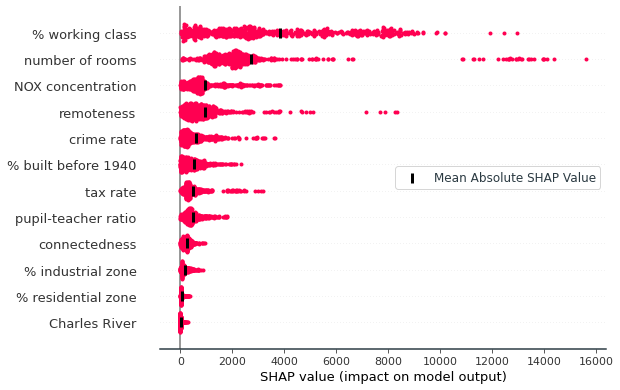

In [44]:
shap.plots.beeswarm(shap_values.abs, color="shap_red", max_display=99, show=False)
fig = plt.gcf()
ax = plt.gca()
masv = []
for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = X.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv.append(mean_abs_sv)
ax.scatter(
    masv,
    [i for i in range(len(X.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100
)
ax.legend(frameon=True)

#### Dependence Plots

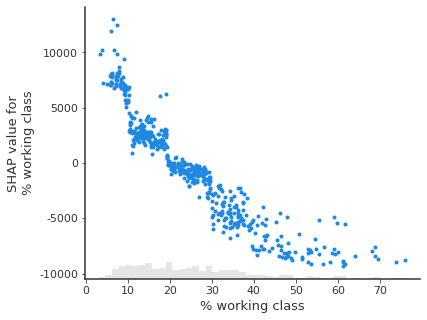

In [17]:
shap.plots.scatter(shap_values[:, "% working class"])

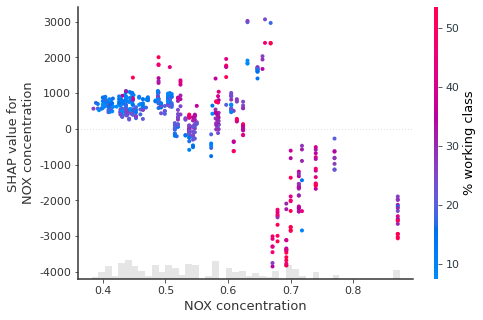

In [18]:
shap.plots.scatter(shap_values[:, "NOX concentration"], color=shap_values)

#### Partial Dependence Plot

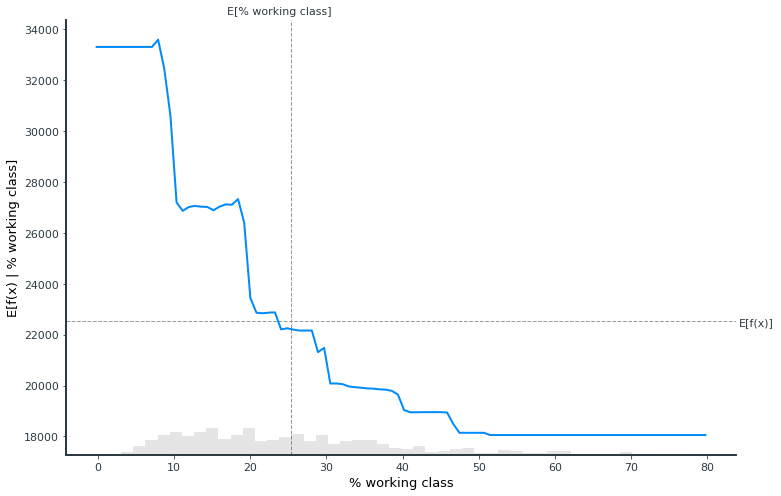

In [19]:
shap.partial_dependence_plot(
    "% working class",
    m.predict,
    X,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False, 
#    shap_values=shap_values[2:3, :]
)

### Interactions

In [20]:
interaction_values = explainer.shap_interaction_values(X)

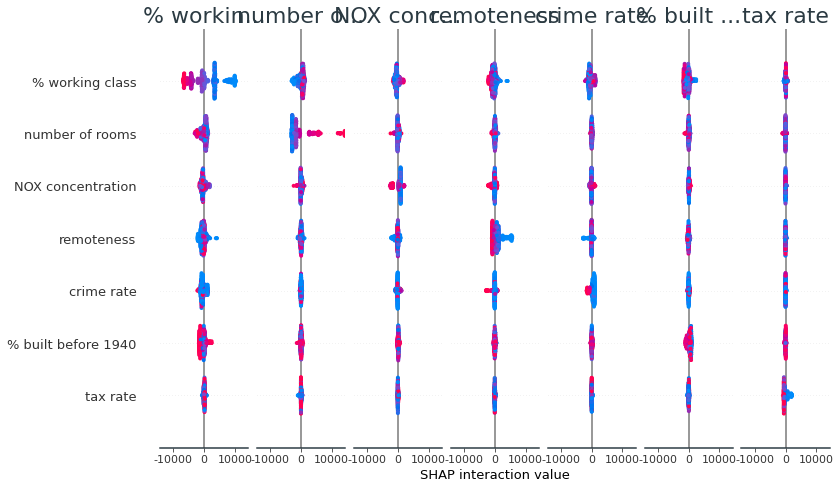

In [21]:
shap.summary_plot(interaction_values, X)

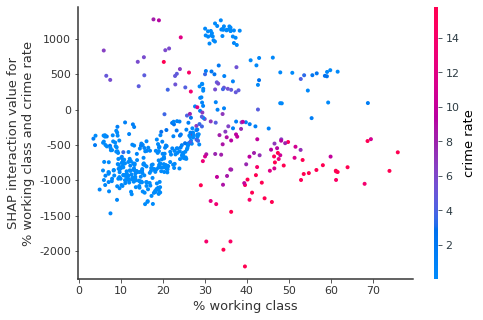

In [22]:
shap.dependence_plot(
    ("% working class", "crime rate"),
    interaction_values,
    X,
)

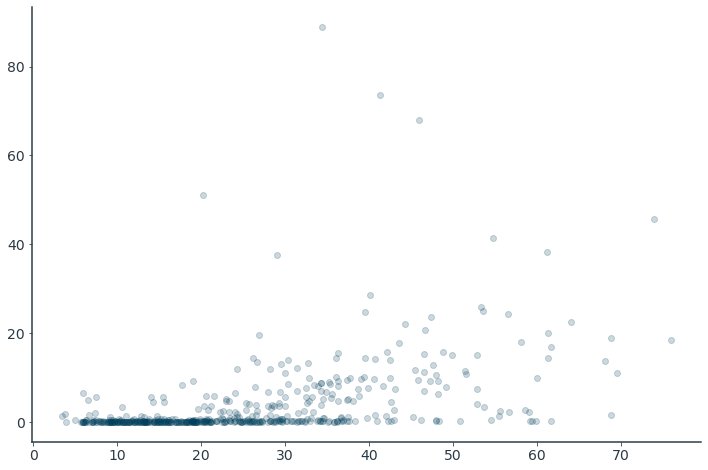

In [23]:
plt.scatter(X["% working class"], X["crime rate"], alpha=0.2)

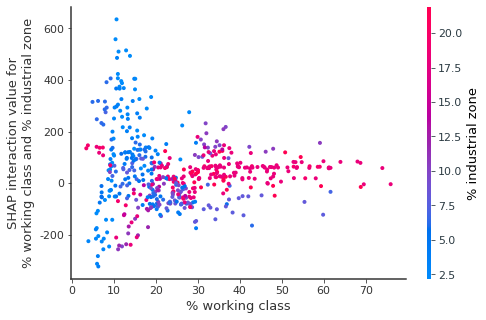

In [24]:
shap.dependence_plot(
    ("% working class", "% industrial zone"),
    interaction_values,
    X,
)